# Introducing the profit machine


In [ ]:
pip install tensorflow==2.2

     |████████████████████████████████| 516.2MB 33kB/s 


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow as tf
import numpy as np
from tensorflow.python.keras.layers.core import *
from tensorflow.python.keras.layers import Conv1D, MaxPooling1D, SimpleRNN, Bidirectional, Input
from tensorflow.python.keras.models import Model, Sequential
from keras.layers import Input, LSTM, Dense, TimeDistributed, Activation, BatchNormalization, Dropout, Bidirectional
from tensorflow import keras

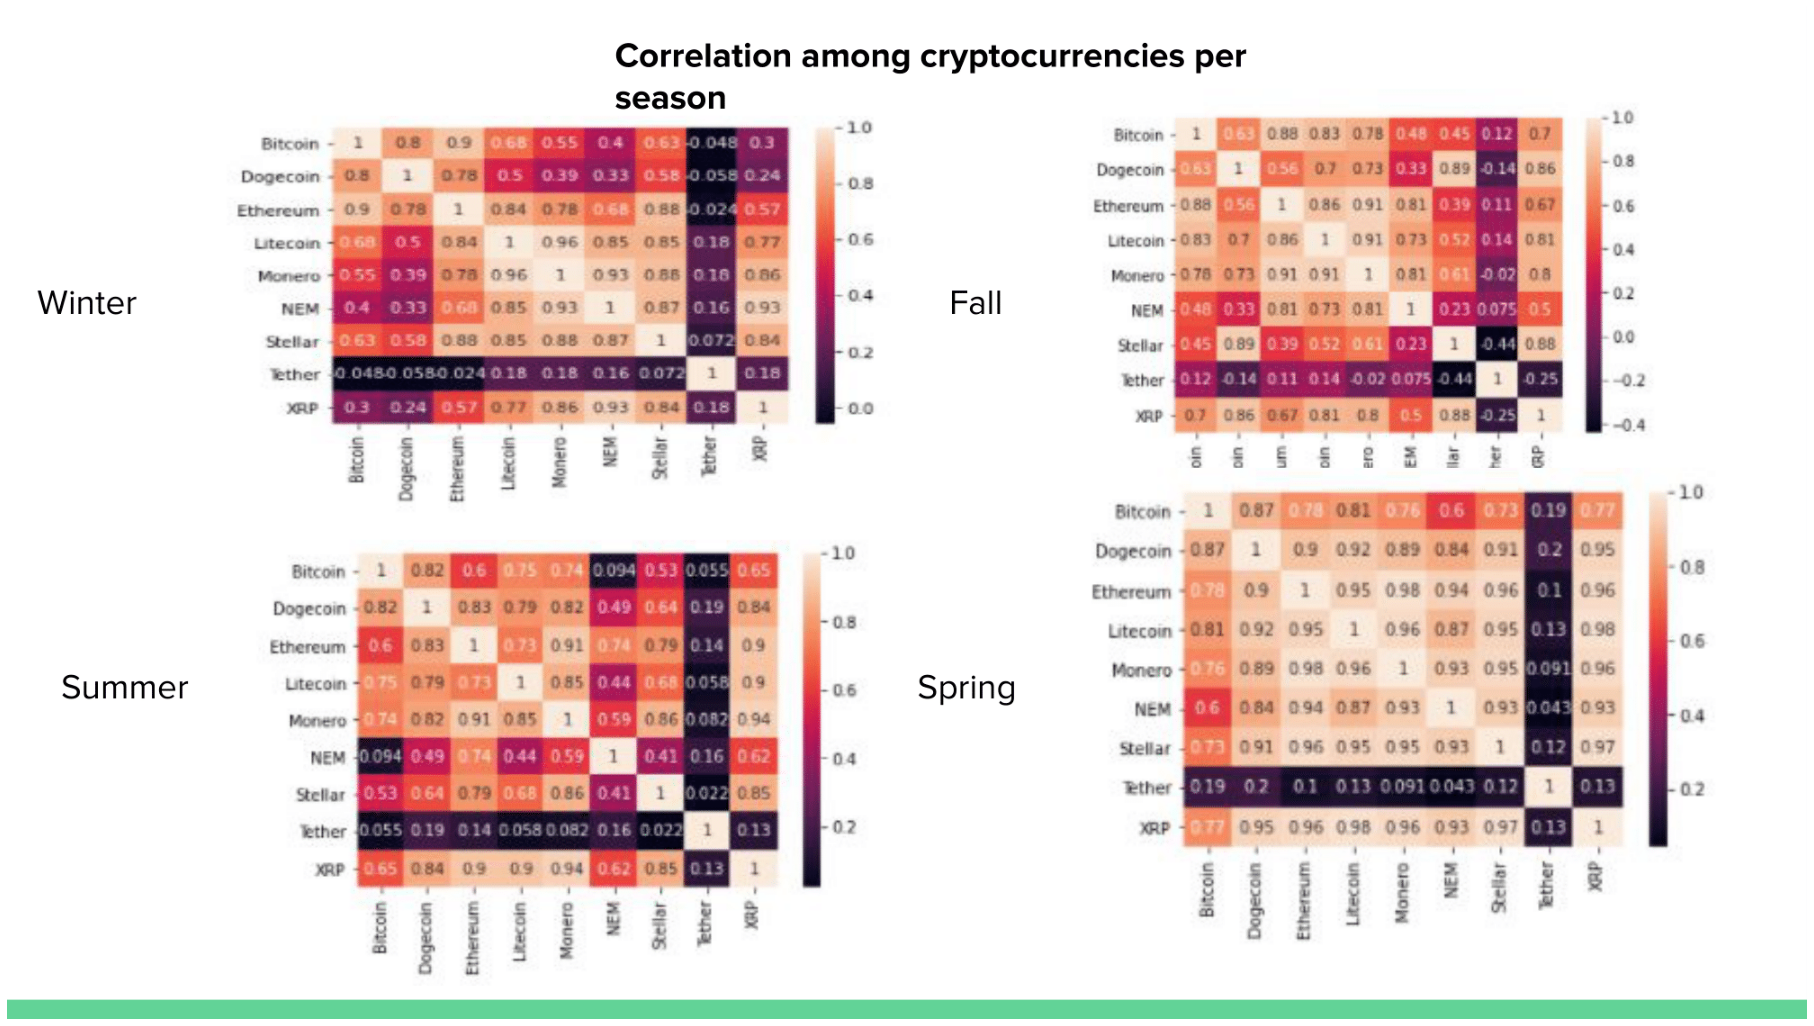

In [ ]:
def display_image_in_actual_size(im_path):

    dpi = 80
    im_data = plt.imread(im_path)
    height, width, depth = im_data.shape

    # What size does the figure need to be in inches to fit the image?
    figsize = width / float(dpi), height / float(dpi)

    # Create a figure of the right size with one axes that takes up the full figure
    fig = plt.figure(figsize=figsize)
    ax = fig.add_axes([0, 0, 1, 1])

    # Hide spines, ticks, etc.
    ax.axis('off')

    # Display the image.
    ax.imshow(im_data, cmap='gray')

    plt.show()

display_image_in_actual_size("correlation.png")


In [ ]:
import os
import requests
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
API_KEY = os.environ.get('COINAPI_KEY', '8D6C105F-4590-483F-82DB-E6B2C64C0FB0')
headers = {
    'X-CoinAPI-Key': API_KEY
}
resp = requests.get('https://rest.coinapi.io/v1/exchanges', headers=headers)

In [ ]:
symbol_id = 'DOGE'
period_id = '1DAY'
time_start = '2019-05-03T00:00:00'
time_end = '2021-05-06T00:00:00'
limit = '1000'

url = f'https://rest.coinapi.io/v1/ohlcv/{symbol_id}/USD/history?period_id={period_id}&time_start={time_start}&time_end={time_end}&limit={limit}'

In [ ]:
import json
response = requests.get(url, headers=headers)
data = json.loads(response.text)
df = pd.DataFrame(data)
df = df.drop(['time_period_end', 'time_open', 'time_close'], axis=1)
df['Date'] = pd.to_datetime(df['time_period_start']).dt.date
df = df.set_index(pd.DatetimeIndex(df['Date'])).drop(['time_period_start', 'Date'], axis=1)
df.head()

,price_open,price_high,price_low,price_close,volume_traded,trades_count
Date,,,,,,
2019-12-20,0.002052,0.002300,0.002000,0.002020,1.009085e+06,50
2019-12-21,0.002100,0.002100,0.002100,0.002100,7.484094e+05,3
2019-12-22,0.002070,0.002103,0.001953,0.002085,2.011168e+06,28
2019-12-23,0.002121,0.002306,0.001997,0.002232,1.965212e+05,20
2019-12-24,0.002216,0.002216,0.002008,0.002008,7.074233e+05,8


In [ ]:
len(df)

503

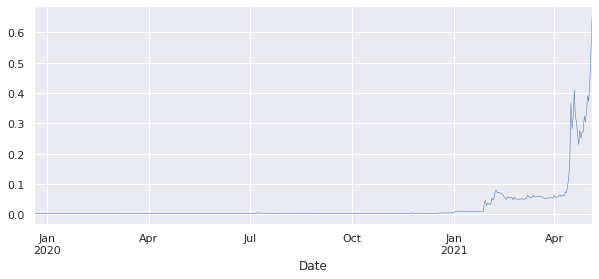

In [ ]:
import matplotlib.pyplot as plt

import seaborn as sns
# Use seaborn style defaults and set the default figure size
sns.set(rc={'figure.figsize':(10, 4)})

df['price_close'].plot(linewidth=0.5);


# Testing dataset

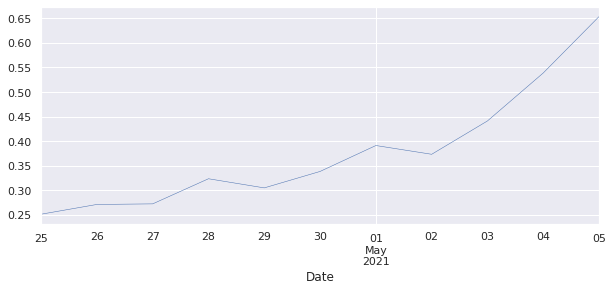

In [ ]:
import matplotlib.pyplot as plt

import seaborn as sns
# Use seaborn style defaults and set the default figure size
sns.set(rc={'figure.figsize':(10, 4)})

df['price_close']['2021-04-25':].plot(linewidth=0.5);

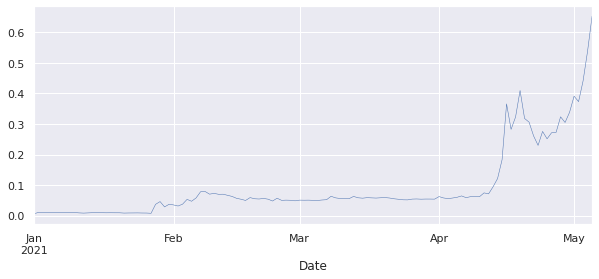

In [ ]:
import matplotlib.pyplot as plt

import seaborn as sns
# Use seaborn style defaults and set the default figure size
sns.set(rc={'figure.figsize':(10, 4)})

df['price_close'].loc['2021'].plot(linewidth=0.5);

In [ ]:
len(df['price_close']['2021-04-15':])

21

In [ ]:
df_crop = df.loc['2021']
df_crop.head()

,price_close
Date,
2021-01-01,0.005708
2021-01-02,0.010578
2021-01-03,0.009846
2021-01-04,0.009792
2021-01-05,0.010000


In [ ]:
test = df_crop['2021-05-01':]

In [ ]:
1- len(test)/len(df_crop)

0.96

## LSTM
Long-Short Term Memory (LSTM) is a type of RNN that allows us to process not only single data points (such as images) but also entire sequences of data (such as speech or video). They are a great choice for time series forecasting, and they are the type of architecture we will be using today.

In [ ]:
scaler = MinMaxScaler()
close_price = df_crop.price_close.values.reshape(-1, 1)
scaled_close = scaler.fit_transform(close_price)

In [ ]:
scaled_close = scaled_close[~np.isnan(scaled_close)]
scaled_close = scaled_close.reshape(-1, 1)

# Sequence Prediction with LSTMs
Creation of a problem that involves using historical sequence information to predict the next value or values in the sequence.LSTMs work by learning a function (f(…)) that maps input sequence values (X) onto output sequence values (y).

In [ ]:

SEQ_LEN = 30


# adding data of 100 sequences to a list, and moving towards the future by 1 step
def to_sequences(data, seq_len):
    d = []

    for index in range(len(data) - seq_len):
        d.append(data[index: index + seq_len])

    return np.array(d)
# 
def preprocess(data_raw, seq_len, train_split):

    data = to_sequences(data_raw, seq_len)

    num_train = int(train_split * data.shape[0])

    X_train = data[:num_train, :-1, :]
    y_train = data[:num_train, -1, :]

    X_test = data[num_train:, :-1, :]
    y_test = data[num_train:, -1, :]

    return X_train, y_train, X_test, y_test


X_train, y_train, X_test, y_test =\
 preprocess(scaled_close, SEQ_LEN, train_split = 0.95)

In [ ]:
from preprocess_script import preprocess

In [ ]:
!pip install numpy

In [ ]:
print('The model will be using 2623 sequences and will be shifting 1 day per window that has length of 99')
len(X_train)

The model will be using 2623 sequences and will be shifting 1 day per window that has length of 99


99

In [ ]:
DROPOUT = 0.2
WINDOW_SIZE = SEQ_LEN - 1

model = keras.Sequential()

model.add(Bidirectional(LSTM(WINDOW_SIZE, return_sequences=True),input_shape=(WINDOW_SIZE, X_train.shape[-1])
))
model.add(Dropout(rate=DROPOUT))

model.add(Bidirectional(
  LSTM((WINDOW_SIZE * 2), return_sequences=True)
))
model.add(Dropout(rate=DROPOUT))

model.add(Bidirectional(
  LSTM(WINDOW_SIZE, return_sequences=False)
))

model.add(Dense(units=1))

model.add(Activation('linear'))

In [ ]:
BATCH_SIZE = 1

model.compile(
    loss='mean_squared_error',
    optimizer='adam'
)

history = model.fit(
    X_train,
    y_train,
    epochs=10,
    batch_size=BATCH_SIZE,
    shuffle=False,
    validation_split=0.1
)

Epoch 1/10
81/81 [==============================] - 12s 61ms/step - loss: 8.3124e-04 - val_loss: 0.1411
Epoch 2/10
81/81 [==============================] - 2s 28ms/step - loss: 0.0316 - val_loss: 0.0219
Epoch 3/10
81/81 [==============================] - 2s 29ms/step - loss: 0.0191 - val_loss: 0.0626
Epoch 4/10
81/81 [==============================] - 2s 27ms/step - loss: 0.0059 - val_loss: 0.3542
Epoch 5/10
81/81 [==============================] - 2s 29ms/step - loss: 0.0012 - val_loss: 0.0053
Epoch 6/10
81/81 [==============================] - 2s 29ms/step - loss: 0.0033 - val_loss: 0.1199
Epoch 7/10
81/81 [==============================] - 2s 29ms/step - loss: 0.0022 - val_loss: 0.1768
Epoch 8/10
81/81 [==============================] - 2s 28ms/step - loss: 0.0031 - val_loss: 0.0284
Epoch 9/10
81/81 [==============================] - 2s 28ms/step - loss: 0.0026 - val_loss: 0.1604
Epoch 10/10
81/81 [==============================] - 2s 28ms/step - loss: 0.0047 - val_loss: 0.0197


In [ ]:
y_hat = model.predict(X_test)
y_test_inverse = scaler.inverse_transform(y_test)
y_hat_inverse = scaler.inverse_transform(y_hat)

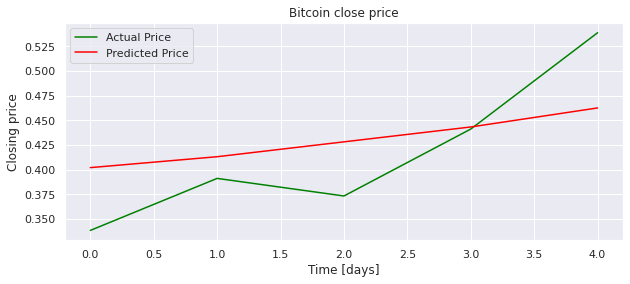

In [ ]:
plt.plot(y_test_inverse, label="Actual Price", color='green')
plt.plot(y_hat_inverse, label="Predicted Price", color='red')

plt.title('Bitcoin close price')
plt.xlabel('Time [days]')
plt.ylabel('Closing price')
plt.legend(loc='best')
 
plt.show();

# Conclusion
Dogecoin originally was basically a 'joke' cryptocurrency has risen nearly 25,000% in the last six months, outpacing nearly every other investment. What this means is that, it initially started off as a low-cap cryptocurrency, and it was one until recently. This dataset is relatively difficult due to the fact since it hasn't been more than a year since this coin has become one of the big fish (#4 ranked based on https://coinmarketcap.com/) in the game. Hence this model considered only 1 year of the coin's history closing value.

## How is the model useful?
The model is not able to catch the fluctuations, but in this instance there will be a winner because it's able to predict the increased value to a certain extend. The huge limitation is the limited data that the model has trained on, therefore the model should be tested on other low-cap coins that have been consistently been low, but are liable options to make financial gains.